In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from scipy.stats import ttest_ind, boxcox, levene, shapiro, kruskal, chi2_contingency

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
DFLINK = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/428/original/bike_sharing.csv?1642089089"
df = pd.read_csv(DFLINK).dropna()

In [4]:
df.shape

(10886, 12)

In [5]:
df.set_index('datetime', inplace=True)
df.index = pd.to_datetime(df.index)
pd.Series(df.columns)

0         season
1        holiday
2     workingday
3        weather
4           temp
5          atemp
6       humidity
7      windspeed
8         casual
9     registered
10         count
dtype: object

In [6]:
categoricalVars = list(df.columns[:4])
numericalVars   = list(df.columns[5:])


for col in categoricalVars:
    df[col] = df[col].astype('category')

df.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

In [7]:
numericalVars

['atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [8]:
categoricalVars

['season', 'holiday', 'workingday', 'weather']

In [9]:
df[numericalVars].describe()

,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
df[categoricalVars].describe()

,season,holiday,workingday,weather
count,10886,10886,10886,10886
unique,4,2,2,4
top,4,0,1,1
freq,2734,10575,7412,7192


In [11]:
seasons = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
holiday = {0: 'non holiday', 1:'holiday'}
workingday = {0: 'non working day', 1:'working day'}
weather = {
    1: 'Clear, Few clouds, partly cloudy, partly cloudy',
    2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
    3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
}

df['season'] = df['season'].cat.rename_categories(seasons)
df['holiday'] = df['holiday'].cat.rename_categories(holiday)
df['workingday'] = df['workingday'].cat.rename_categories(workingday)


pd.DataFrame(
    {
        'number of categories': [df[col].nunique() for col in categoricalVars],
        'categories': [set(df[col].unique()) for col in categoricalVars]
    },
    index = categoricalVars
)

,number of categories,categories
season,4,"{fall, spring, summer, winter}"
holiday,2,"{non holiday, holiday}"
workingday,2,"{working day, non working day}"
weather,4,"{1, 2, 3, 4}"


In [12]:
df[categoricalVars[0]].value_counts()

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64

In [13]:
df[categoricalVars[1]].value_counts()

holiday
non holiday    10575
holiday          311
Name: count, dtype: int64

In [14]:
df[categoricalVars[2]].value_counts()

workingday
working day        7412
non working day    3474
Name: count, dtype: int64

In [15]:
df[categoricalVars[3]].value_counts()

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

In [16]:
def calculate_outliers(data:pd.Series):
    Q25 = data.quantile(0.25)
    Q75 = data.quantile(0.75)
    IQR = Q75 - Q25

    OUTLIER_THRESHOLD_MIN = max(min(data), Q25 - 1.5*IQR)

    OUTLIER_THRESHOLD_MAX = min(max(data), Q75 + 1.5*IQR)

    OUTLIER_COUNT = (data < OUTLIER_THRESHOLD_MIN).sum() + (data > OUTLIER_THRESHOLD_MAX).sum()

    return {
        'Q25': Q25,
        'MEDIAN': data.median(),
        'MEAN': round(data.mean(),2),
        'Q75': Q75,
        'IQR': IQR,
        'OUT_MIN': OUTLIER_THRESHOLD_MIN,
        'OUT_MAX': OUTLIER_THRESHOLD_MAX,
        'OUTLIER_COUNT': str(OUTLIER_COUNT),
        'TOTAL_COUNT': len(data),
        'OUTLIERS_%': round(100*OUTLIER_COUNT/len(df),2)
    }

data = {}
for var in numericalVars:
    data.update(
        {var: calculate_outliers(df[var])}
    )

outlierInfo = pd.DataFrame(data)
outlierInfo

,atemp,humidity,windspeed,casual,registered,count
Q25,16.665,47.0,7.0015,4.0,36.0,42.0
MEDIAN,24.24,62.0,12.998,17.0,118.0,145.0
MEAN,23.66,61.89,12.8,36.02,155.55,191.57
Q75,31.06,77.0,16.9979,49.0,222.0,284.0
IQR,14.395,30.0,9.9964,45.0,186.0,242.0
OUT_MIN,0.76,2.0,0.0,0,0,1
OUT_MAX,45.455,100,31.9925,116.5,501.0,647.0
OUTLIER_COUNT,0,22,227,749,423,300
TOTAL_COUNT,10886,10886,10886,10886,10886,10886
OUTLIERS_%,0.0,0.2,2.09,6.88,3.89,2.76


In [17]:
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# Univariate Analysis

In [22]:
def univariateAnalysisOfNumericalVar(col):
    fig, axes = plt.subplots(2, 1, figsize=(9,4), height_ratios=[1, 4])
    fig.suptitle('Univariate Analysis')

    sns.boxplot(data=df[[col]], x=col, ax = axes[0])

    sns.histplot(data=df[[col]], x=col, ax = axes[1], kde=True)
    plt.show()

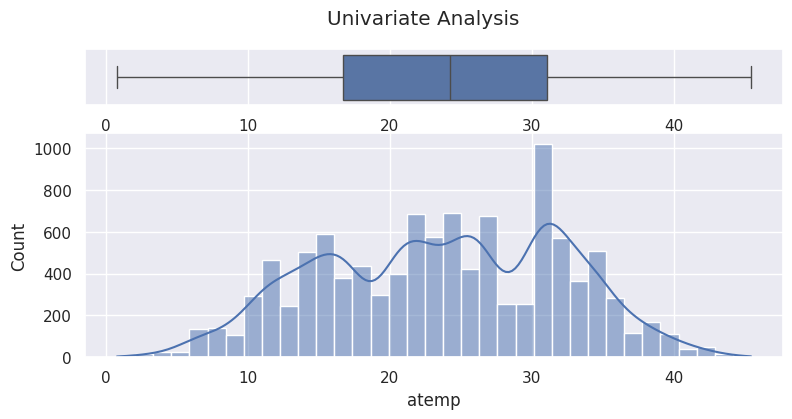

In [23]:
univariateAnalysisOfNumericalVar(numericalVars[0])

## For temperature, Minimum is 0.76 C, maximum is 45.45 C and median is 24.24 C and average is at 23.66 C`

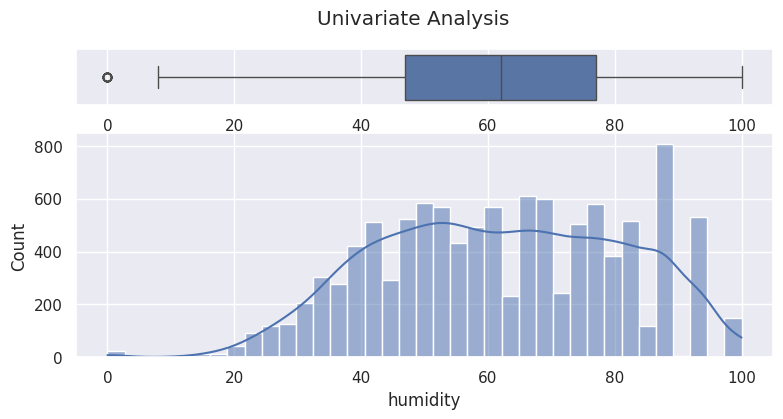

In [24]:
univariateAnalysisOfNumericalVar(numericalVars[1])

## For humidity, minimum is 0%, maximum is 100% and median is 62% and average is at 61.89%`

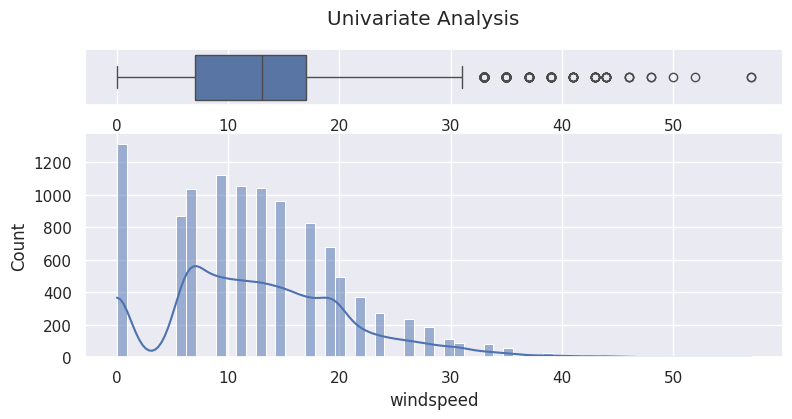

In [25]:
univariateAnalysisOfNumericalVar(numericalVars[2])

##For windspeed, mimum is 0 mph, maximum is 32 mph, median is 13 mph and average is at 12.89 mph %`

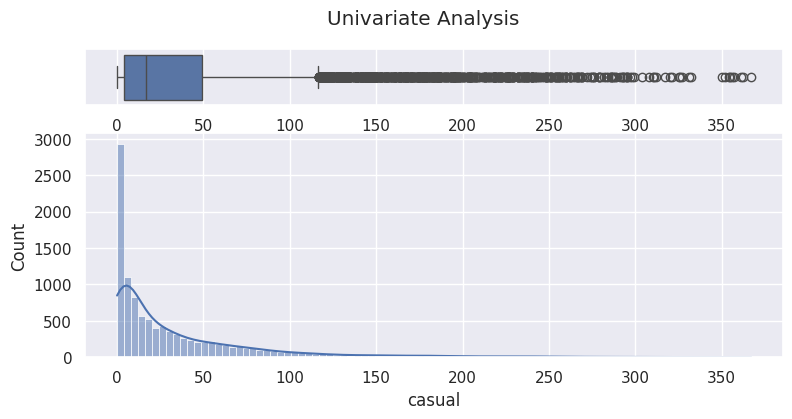

In [26]:
univariateAnalysisOfNumericalVar(numericalVars[3])

## For casual count, maximum is 367 and median 17 and average is at 36, data is highly right skewed`

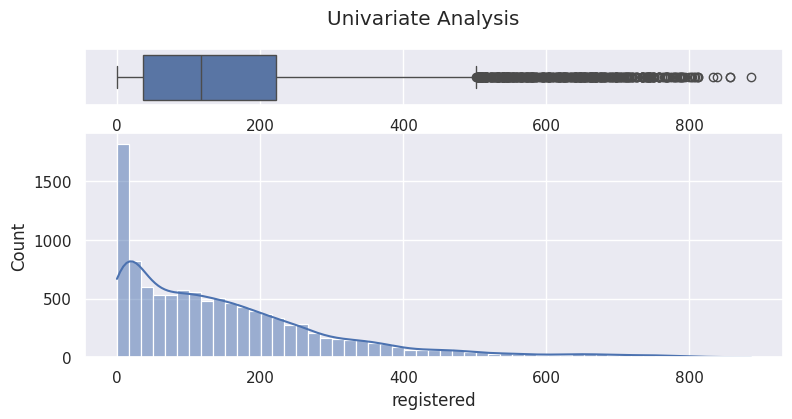

In [27]:
univariateAnalysisOfNumericalVar(numericalVars[4])

## For regeistered count, maximum is 886 and median 118 and average is at 155.6, data is highly right skewed`

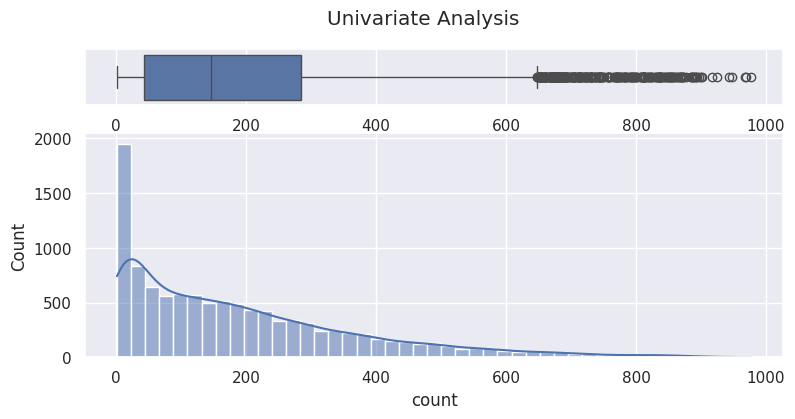

In [28]:
univariateAnalysisOfNumericalVar(numericalVars[5])

## For total count, min is 1, maximum is 977 and median 145 and average is at 191, data is highly right skewed`

In [33]:
def univariateAnalysisOfCategoricalVar(col):
    df_c = df[col].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Univariate Analysis')

    sns.countplot(data=df, x=col, ax=axes[0])
    axes[0].bar_label(axes[0].containers[0], df[col].value_counts().values)

    axes[1].pie(df_c, labels=df_c.index, data=df_c.values, autopct='%0.2f%%')

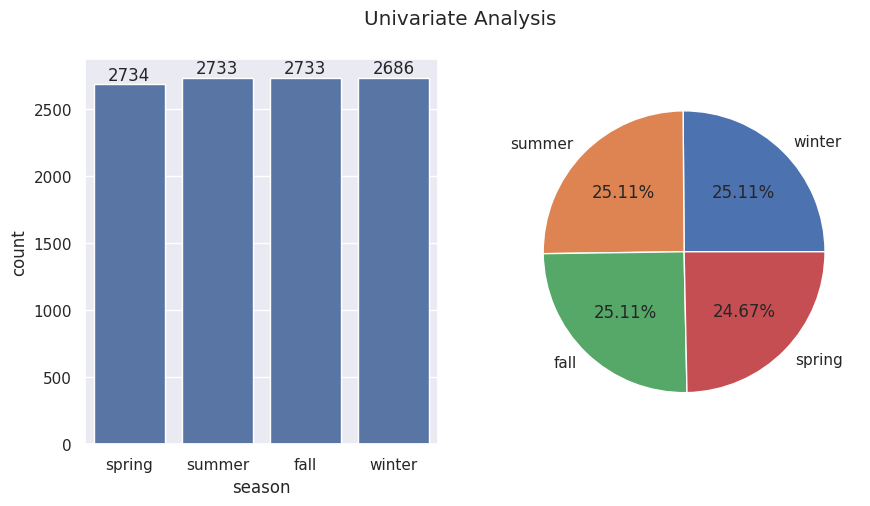

In [34]:
univariateAnalysisOfCategoricalVar(categoricalVars[0])

## Seasons are approximately in equal proportions`

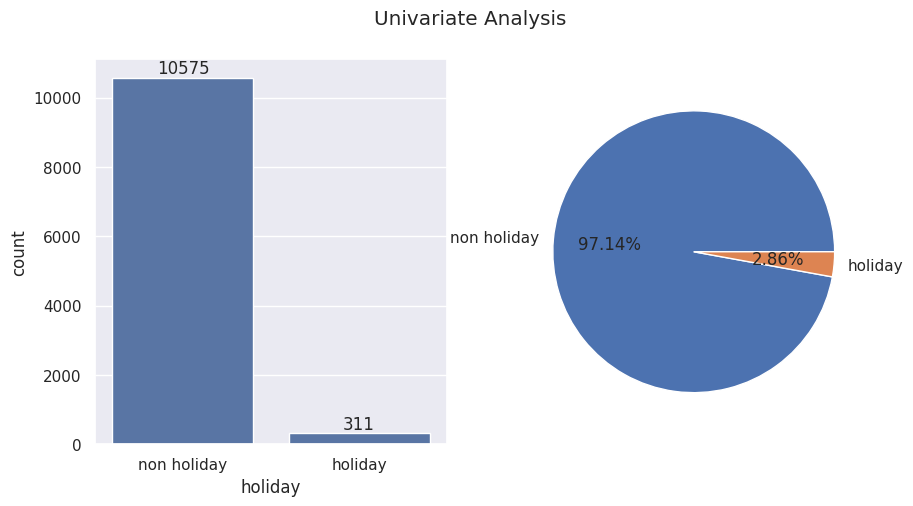

In [35]:
univariateAnalysisOfCategoricalVar(categoricalVars[1])

## less than 3% of of data is from holidays`

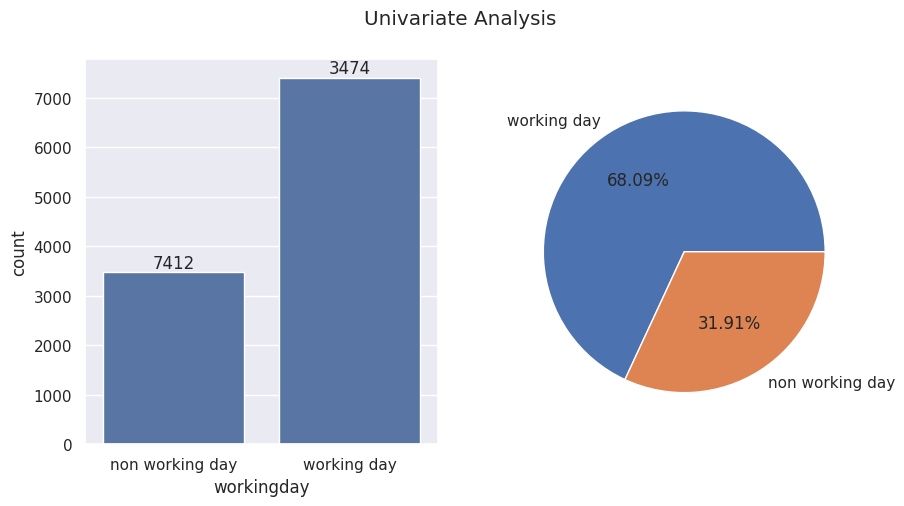

In [36]:
univariateAnalysisOfCategoricalVar(categoricalVars[2])

## Almost 30% data is for non working days. `

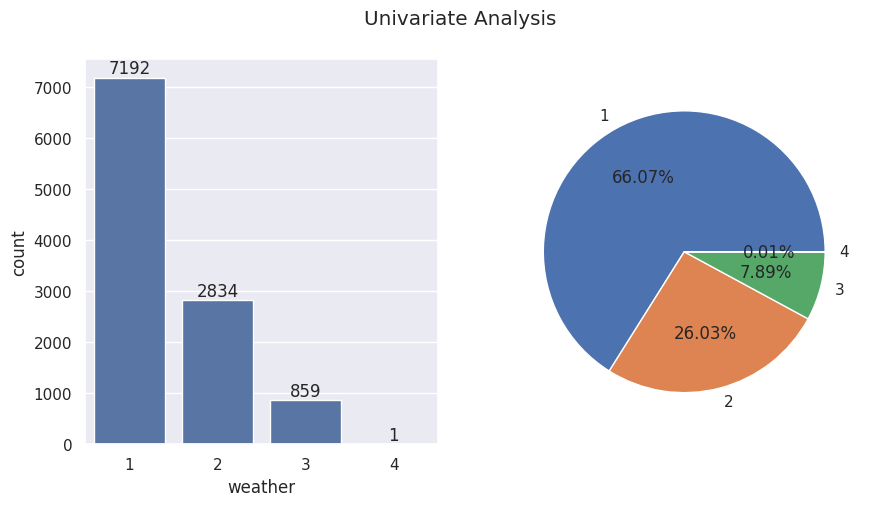

In [37]:
univariateAnalysisOfCategoricalVar(categoricalVars[3])

# Bivariate Analysis

In [39]:

def bivariateAnalysis(cvar, nvar):
    fig = plt.figure(layout='constrained', figsize=(16, 5))
    fig.suptitle(f'Bivariate Analysis {cvar} vs {nvar}')
    subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2, 1])

    axes = subfigs[0].subplots(2, 1, sharex=True, height_ratios=[3.5, 1.5])

    kdeAx = axes[0]
    df_split = pd.pivot(df, columns=cvar, values=nvar)
    sns.histplot(data=df_split, ax=kdeAx).set(yticklabels=[])

    boxAx = axes[1]
    sns.boxplot(data=df, x=nvar, y=cvar, ax=boxAx, orient='h')
    boxAx.set_ylabel(None)


    barAx = subfigs[1].subplots(1)
    subfigs[1].suptitle(f'Average ({nvar})\n')
    sns.barplot(data=df, x=cvar, y=nvar, estimator='mean', ax=barAx, errorbar=None)
    barAx.bar_label(barAx.containers[0])

    plt.show()

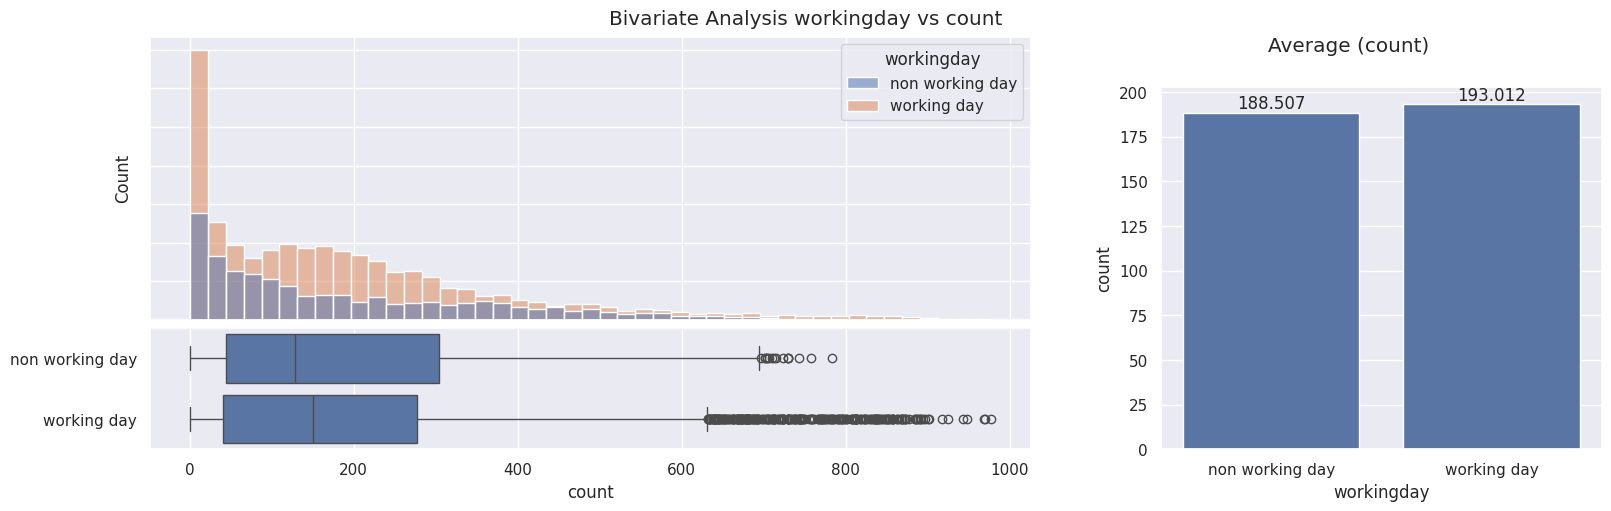

In [40]:
bivariateAnalysis('workingday', 'count')

## Average and median of count (of rental bikes) across both workday and non workday is almost same, data is almost equally spread (variance) is both categories (working and non working days)`

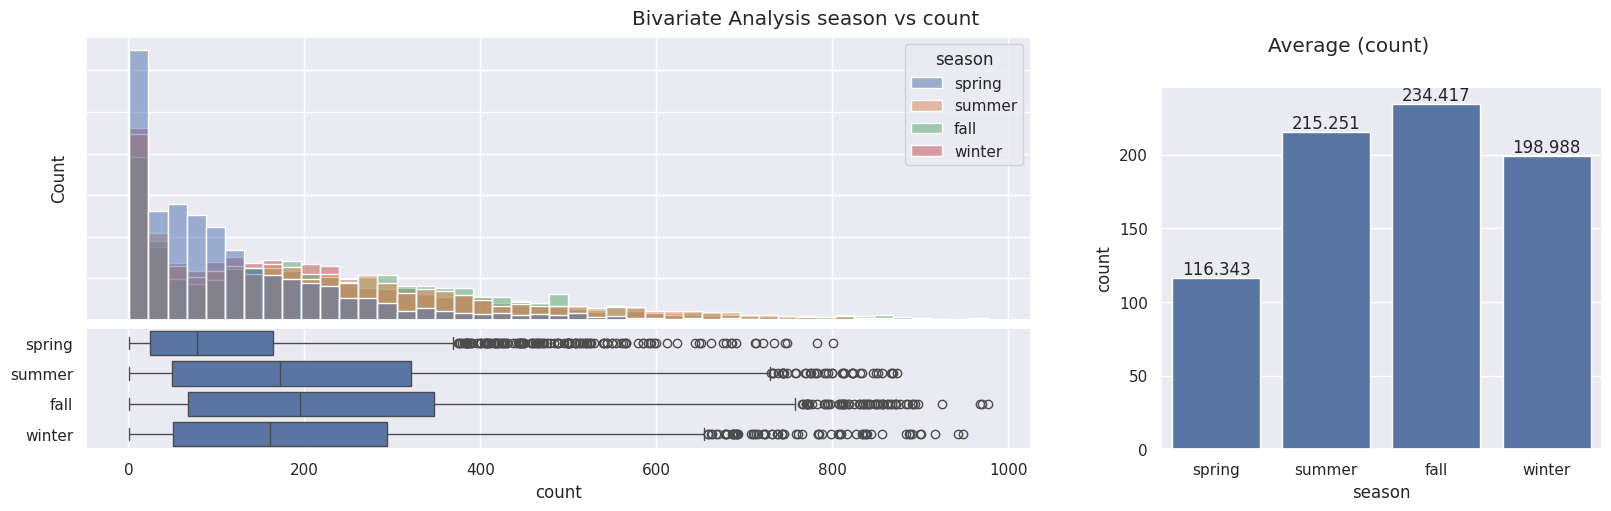

In [41]:
bivariateAnalysis('season', 'count')

## We observe less rented-bike-count in spring season compared to other seasons, Average count for fall season is the highest. Data is right skewed.

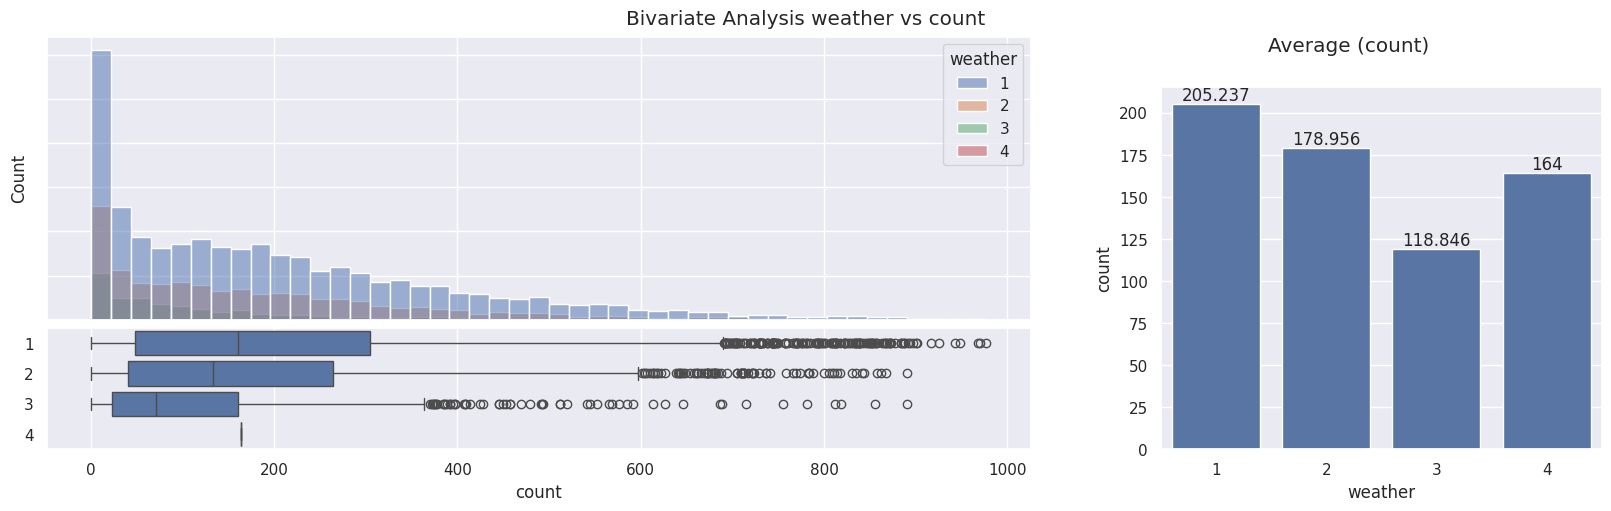

In [42]:
bivariateAnalysis('weather', 'count')

In [43]:
weather

{1: 'Clear, Few clouds, partly cloudy, partly cloudy',
 2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
 3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
 4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}

# 1. Workingday vs Count

## Set up H0
```
Test : 2-sample t test
Null Hypothesis H0 : Working day has no effect on number of cycles rented
Alternate Hypothesis H1: Working day has effect on number of cycles rented
Significance Level : 5%
```

## Assumptions of 2 Sample t test
```
1. Independent groups
2. Variances are same
3. Population Distribution is approximately normal
4. Data is sampled randomly (50 sample size which is > 30 )
```

### Random Sample

In [44]:
SAMPLESIZE = 100
catVar = 'workingday'
data = {cat:(df['count'][df[catVar]==cat]).dropna().sample(SAMPLESIZE).to_list() for cat in df[catVar].unique()}

### Normality

<Axes: ylabel='Count'>

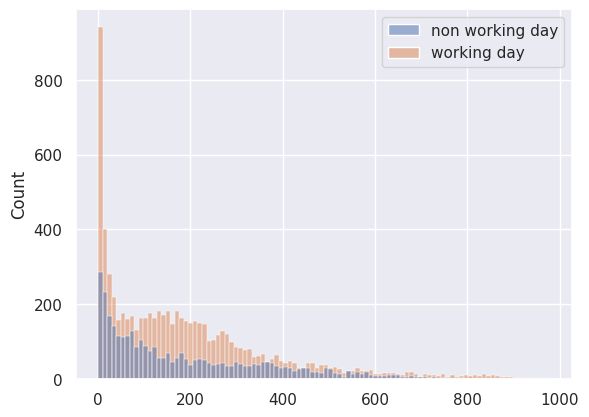

In [45]:
# visual check
data_population = {cat:(df['count'][df['workingday']==cat]).to_list() for cat in df['workingday'].unique()}

sns.histplot(data_population, bins=100)

### Shapiro Test for Normality

In [46]:
for cat in data:
    L, p = shapiro(data[cat])

    if p < 0.05:
        print('Reject H0: p = ', p)
        print(f'sample data of {catVar}={cat} are not from normally distributed population.')
    else:
        print('Accept H0: p = ', p)
        print(f'sample data of {catVar}={cat} are from normally distributed population.')
    print('')

Reject H0: p =  1.667194027277219e-07
sample data of workingday=non working day are not from normally distributed population.

Reject H0: p =  7.543230928774847e-09
sample data of workingday=working day are not from normally distributed population.



### Homogenety of variances

In [47]:
df.pivot(columns='workingday', values='count').var()

workingday
non working day    30180.033501
working day        34045.290373
dtype: float64

## Validity of assumptions:
```
1. Independent groups:
    count data for working day and non-working dat are not affecting each other. So, OK!
2. Variances are same:
    variances are nearly same for 2 groups (~30 k and ~34k)
3. Population Distribution is approximately normal
    This is not satisfied for our case, as we see from the above shapiro test.
    As it is mentioned in assignment question:
        "Please continue doing the analysis even If some assumptions fail",
    We will still perform t-test
4. Data is sampled randomly
    (100 sample size which is > 30 )
```

In [48]:
t_score, p = \
ttest_ind(
    *(data.values())
)

alpha = 0.05 # 95% confidence

if p < alpha:
    print('Reject H0\tp =', p, '\tt=', t_score)
    print('H0: count in workday and non-working day are differnet (µ1 ≠ µ2)')
else:
    print('Failed to reject H0\tp =', p, '\tt =', t_score)
    print('H0: count in workday and non-working day are similar (µ1 = µ2)')

Failed to reject H0	p = 0.22457078574355693 	t = 1.2182706802104917
H0: count in workday and non-working day are similar (µ1 = µ2)


## Comments:
`21. From the t test we see that total count of rental bikes is similar for both working day and non working day`


# 2. Weather vs Count

In [49]:
df.pivot(columns='weather', values='count').sample(5)

weather,1,2,3,4
datetime,,,,
2011-12-12 10:00:00,NaN,105.0,NaN,NaN
2011-08-02 16:00:00,274.0,NaN,NaN,NaN
2012-10-19 14:00:00,365.0,NaN,NaN,NaN
2012-01-16 22:00:00,NaN,43.0,NaN,NaN
2012-11-14 21:00:00,213.0,NaN,NaN,NaN


## Test
```
Test: ANOVA
Null Hypothesis: There is no difference of count of rented bikes across different weather types.
Alternate Hypothesis: count of rented bikes for atleast one weather type is different than that of other weather types.

Significance Level : 5%
```
## Assumptions of ANOVA
```
1. The response variable is continous: True, count is continous
2. Homogenity of variances across groups in population.
3. Sample data is from normally distribution
```

### 1. Response variable is continous:

In [50]:
df.pivot(columns='weather', values='count').count()

weather
1    7192
2    2834
3     859
4       1
dtype: int64

```
As we can see there aren't enough data points for weather=4, so we drop this category
```

In [51]:
selected_weather = [1,2,3]

### 2. Sample for tests

In [52]:
SAMPLESIZE = 100
catVar = 'weather'
data = {cat:(df['count'][df[catVar]==cat]).dropna().sample(SAMPLESIZE).to_list() for cat in selected_weather}

### 3. Levene Test for homogenity of variances

In [53]:
L, p = levene(*data.values())

if p < 0.05:
    print('Reject H0: p = ', p)
    print('all input samples are from populations with unequal variances.')
else:
    print('Accept H0: p = ', p)
    print('all input samples are from populations with equal variances.')

Reject H0: p =  0.02233833568024647
all input samples are from populations with unequal variances.


```
Levene's test failed, groups have unequal variances.
```

### 4. Shapiro's Test for normality

In [54]:
for cat in data:
    L, p = shapiro(data[cat])

    if p < 0.05:
        print('Reject H0: p = ', p)
        print(f'sample data of {catVar}={cat} are not from normally distributed population.')
    else:
        print('Accept H0: p = ', p)
        print(f'sample data of {catVar}={cat} are from normally distributed population.')
    print('')

Reject H0: p =  2.1202619393534405e-07
sample data of weather=1 are not from normally distributed population.

Reject H0: p =  2.065040825982578e-05
sample data of weather=2 are not from normally distributed population.

Reject H0: p =  5.468328697841307e-13
sample data of weather=3 are not from normally distributed population.



```
From shapiro test, we see that none of samples of each group are from normal distribution.
We will go forward with:
```
### 4. Kruskal Wallis test
[Assumptions: Kruskal Wallis](https://www.statisticssolutions.com/kruskal-wallis-test/):
```
1. Independence of data set (This is satisfied)
2. Randomly sampled data (Also true)
```

In [55]:
# kruskal Wallis
stat, p = kruskal(*data.values())

if p < 0.05:
    print("Reject H0, p = ",p)
    print("Atleast one group have different median")
else:
    print("Fail to reject H0, p = ", p)
    print("All groups have same median")

Reject H0, p =  0.0023939335512177125
Atleast one group have different median


`22: From ~ANOVA~ Kruskal Wallis Test: We conclude that there is a correlation between weather and count of total rented bikes`

# 3. Season vs Count

In [56]:
df.pivot(columns='season', values='count').sample(5)

season,spring,summer,fall,winter
datetime,,,,
2011-06-13 22:00:00,NaN,134.0,NaN,NaN
2012-02-07 07:00:00,299.0,NaN,NaN,NaN
2012-08-16 13:00:00,NaN,NaN,300.0,NaN
2011-06-14 16:00:00,NaN,330.0,NaN,NaN
2011-10-05 16:00:00,NaN,NaN,NaN,282.0


## Test
```
Test: ANOVA
Null Hypothesis: There is no difference of count of rented bikes across different seasons.
Alternate Hypothesis: count of rented bikes for atleast one season is different than that of other seasons.

Significance Level : 5%
```
## Assumptions of ANOVA
```
1. The response variable is continous: True, count is continous
2. Homogenity of variances across groups in population.
3. Sample data is from normally distribution

Significance Level : 5%
```

### 1. Response variable is continous:

In [57]:
df.pivot(columns='season', values='count').count()

season
spring    2686
summer    2733
fall      2733
winter    2734
dtype: int64

### 2. Sample for tests

In [58]:
SAMPLESIZE = 100
catVar = 'season'
data = {cat:(df['count'][df[catVar]==cat]).dropna().sample(SAMPLESIZE).to_list() for cat in df[catVar].unique()}

### 3. Levene Test for homogenity of variances

In [59]:
L, p = levene(*data.values())

if p < 0.05:
    print('Reject H0: p = ', p)
    print('all input samples are from populations with unequal variances.')
else:
    print('Accept H0: p = ', p)
    print('all input samples are from populations with equal variances.')

Reject H0: p =  0.0020625409504389613
all input samples are from populations with unequal variances.


```
Levene's test failed, groups have unequal variances.
```

### 4. Shapiro's Test for normality

In [60]:
for cat in data:
    L, p = shapiro(data[cat])

    if p < 0.05:
        print('Reject H0: p = ', p)
        print(f'sample data of {catVar}={cat} are not from normally distributed population.')
    else:
        print('Accept H0: p = ', p)
        print(f'sample data of {catVar}={cat} are from normally distributed population.')
    print('')

Reject H0: p =  1.5988639301411922e-09
sample data of season=spring are not from normally distributed population.

Reject H0: p =  6.661157669896056e-08
sample data of season=summer are not from normally distributed population.

Reject H0: p =  3.9235601434484124e-05
sample data of season=fall are not from normally distributed population.

Reject H0: p =  4.949897203232467e-08
sample data of season=winter are not from normally distributed population.



```
From shapiro test, we see that none of samples of each group are from normal distribution.
We will go forward with:
```
### 4. Kruskal Wallis test

[Assumptions: Kruskal Wallis](https://www.statisticssolutions.com/kruskal-wallis-test/):
```
1. Independence of data set (This is satisfied)
2. Randomly sampled data (Also true)

Significance Level : 5%
```

In [61]:
# kruskal Wallis
stat, p = kruskal(*data.values())

if p < 0.05:
    print("Reject H0, p = ",p)
    print("Atleast one group have different median")
else:
    print("Fail to reject H0, p = ", p)
    print("All groups have same median")

Reject H0, p =  0.0019224101039959321
Atleast one group have different median


`23: From ~ANOVA~ Kruskal Wallis Test: We conclude that there is a correlation between seasons and count of total rented bikes`

# 4. Weather vs Season

```
Test: Chi^2
Significance Level : 5%
H0 : Null Hypothesis: Weather and Season are associated
H1: Alternate Hypothesis: Weather and Season are not associated

Assumptions:
1. Indpendence of categories
2. Random selection of data
3. Categorical data is used.
4. Frequency data is used as aggregate for each cell value.

All assumptions are satisfied
```


In [62]:
result = chi2_contingency(pd.crosstab(df['weather'], df['season']))

if result.pvalue < 0.05:
    print("Reject H0, p = ", p)
    print("Weather and Seasons are not independent, (they ARE ASSOCIATED)")
else:
    print("Fail to reject H0, p = ", p)
    print("Weather and Seasons are independent")

Reject H0, p =  0.0019224101039959321
Weather and Seasons are not independent, (they ARE ASSOCIATED)


`24: From Chi-Squred Test: We conclude that there is a weather and seasons are associated`

# Summary
```
1: We have 10886 records of data with 12 columns
2: As shown above, 'season', 'holiday', 'workingday', 'weather' are categorical variables and rest: atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count' are numerical variables
3: There is almost equal amounts of data across all 4 seasons
4. Most of the data is from Non-Holidays and very less (~3%) is from holidays
5: We have data from working and non working days in about to 70/30 ratio
6: There is very less data for weather=4 (Exactly 1 data point) and most of data points is from weather=1
7: All numerical variables have very less outliers (less than 3%)
8: There are no null values
9: For temperature, Minimum is 0.76 C, maximum is 45.45 C and median is 24.24 C and average is at 23.66 C
10: For humidity, minimum is 0%, maximum is 100% and median is 62% and average is at 61.89%
11: For windspeed, mimum is 0 mph, maximum is 32 mph, median is 13 mph and average is at 12.89 mph %
12: For casual rented-bike-count, maximum is 367 and median 17 and average is at 36, data is highly right skewed
13: For regeistered rented-bike-count, maximum is 886 and median 118 and average is at 155.6, data is highly right skewed
14: For total count, min is 1, maximum is 977 and median 145 and average is at 191, data is highly right skewed
15: Seasons are approximately in equal proportions
16: less than 3% of of data is from holidays
17. Weather type=1 (clear skies,Partly cloudy) is about 66% of the data points, while type=2 (mist or cloudy) is about 26% of the data points.
Very few data points are collected during type=3 weather (light snow or light rain condition) (8%)
There are almost no datapoints for weather type=4 (Exactly 1).
18: Average and median of count (of rental bikes) across both workday and non workday is almost same, data is almost equally spread (variance) is both categories (working and non working days)
19: We observe less rented-bike-count in spring season compared to other seasons, Average count for fall season is the highest. Data is right skewed.
20: There are very less values in weather type=4, Average in each weather category is different, highest being in 1 which is Clear, Few clouds, partly cloudy, partly cloudy. Which makes more sense as it is comfortable to use bikes in clear weather compared to rainy weather, there is very less data for heavy rain weather, as it is difficuly to use bike in such weather
21. From the t test we see that total count of rental bikes is similar for both working day and non working day
22: From ~ANOVA~ Kruskal Wallis Test: We conclude that there is a correlation between weather and count of total rented bikes
23: From ~ANOVA~ Kruskal Wallis Test: We conclude that there is a correlation between seasons and count of total rented bikes
24: From Chi-Squred Test: We conclude that there is a weather and seasons are associated
```

# Recommendations

```
1. Discounts to encourange usage of yulu rental bikes for holidays and non working days and we observe less count of total rental bikes in those days.
2. Promotional campaigns during spring season: As we observe less bikes being rented in spring season
```